# **# NLP Dataset: Twitter Sentiment Analysis**(Using Text Level GNN)

# **# 1. Import Libraries/Dataset**


In [6]:
# DataFrame
import pandas as pd

#Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
from keras.optimizers import Adam

# Scikit-learn
from sklearn.model_selection import train_test_split


# Utility
import re
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib for data visualisation
from sklearn.metrics import confusion_matrix

#For glove
import torch
import torchtext


In [7]:
# DATASET
DATASET_COLUMNS = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"


# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


**#. Import Data Set for Sentiment Analysis using Googe Drive (Below is the backup option in case kaggle API having issues to load data.

In [8]:
# Code to read csv file into Colaboratory:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
dataset = pd.read_csv(r"/content/drive/My Drive/Dissertation/Kaggle Sentiment140.csv",encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

**#. Import Data Set for Sentiment Analysis directly from Kaggle**

In [10]:
#!mkdir -p ~/.kaggle

In [11]:
#!cp kaggle.json ~/.kaggle/

In [12]:
#!ls ~/.kaggle

In [13]:
#!cp kaggle.json ~/.kaggle/

In [14]:
#!chmod 600 /root/.kaggle/kaggle.json

In [15]:
#!echo '{"username":"preetamkumar","key":"02e539250914c9fea2c057a45b87339b"}' > /root/.kaggle/kaggle.json
#!chmod 600 /root/.kaggle/kaggle.json

In [16]:
#!kaggle datasets download -d kazanova/sentiment140 -p /content

In [17]:
#!unzip \*.zip

In [18]:
#dataset = pd.read_csv('training.1600000.processed.noemoticon.csv' , encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [54]:
print(len(dataset))

1600000


In [56]:
dataset.columns

Index(['sentiment', 'text'], dtype='object')

In [57]:
dataset.describe()

,sentiment
count,1600000.0
mean,0.5
std,0.5
min,0.0
25%,0.0
50%,0.5
75%,1.0
max,1.0


In [58]:
dataset.head(5)

,sentiment,text
0,0,A that s a bummer You shoulda got David Carr ...
1,0,is upset that he can t update his Facebook by ...
2,0,I dived many times for the ball Managed to s...
3,0,my whole body feels itchy and like its on fire
4,0,no it s not behaving at all i m mad why am...


In [59]:
dataset.tail()

,sentiment,text
1599995,1,Just woke up Having no school is the best fee...
1599996,1,TheWDB com Very cool to hear old Walt interviews
1599997,1,Are you ready for your MoJo Makeover Ask me f...
1599998,1,Happy 38th Birthday to my boo of a time Tupac...
1599999,1,happy charitytuesday


In [61]:
# Removing the unnecessary columns.
#dataset = dataset.drop(columns = ["ids", "date", "flag", "user"])

# **# 2. Data Visualization**

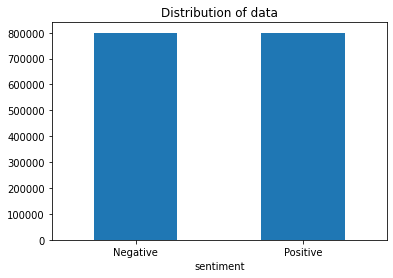

In [62]:
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [63]:
dataset.sentiment.unique()

array([0, 1])

In [64]:
dataset.groupby('sentiment').nunique()

,text
sentiment,
0,777436
1,769268


In [66]:
print ("No of postive sentiment tweets:")
n_positive = len(dataset[dataset['sentiment'] == 1])
print(n_positive)

No of postive sentiment tweets:
800000


In [67]:
print ("No of negative sentiment tweets:")
n_negative = len(dataset[dataset['sentiment'] == 0])
print(n_negative)

No of negative sentiment tweets:
800000


In [68]:
# Print at least 2 tweets from each class of data set for the sanity check that labels match the text
# Print +ve reviws
print('Print at least 2 tweets from positive sentiment:')
dataset_pos = dataset[dataset['sentiment'] == 1]
dataset_pos.head(5)

Print at least 2 tweets from positive sentiment:


,sentiment,text
800000,1,I LOVE u guys r the best
800001,1,im meeting up with one of my besties tonight ...
800002,1,Thanks for the Twitter add Sunisa I got to ...
800003,1,Being sick can be really cheap when it hurts t...
800004,1,he has that effect on everyone


In [69]:
# Print at least 2 tweets from each class of data set for the sanity check that labels match the text
# Print -ve reviws
print('Print at least 2 tweets from negative sentiment:')
dataset_neg = dataset[dataset['sentiment'] == 0]
dataset_neg.head(5)

Print at least 2 tweets from negative sentiment:


,sentiment,text
0,0,A that s a bummer You shoulda got David Carr ...
1,0,is upset that he can t update his Facebook by ...
2,0,I dived many times for the ball Managed to s...
3,0,my whole body feels itchy and like its on fire
4,0,no it s not behaving at all i m mad why am...


# **#3. Data Pre-processing**

In [70]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}


In [71]:
#Removing Twitter Handles(@user)
#User Defined function to remove patten
#Removing Twitter Handles(@user)
#User Defined function to remove patten
#Removing Emojis

def preprocess(tweet):
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
        
                  
    # Replace all URls with 'URL'
    tweet = re.sub(urlPattern,' URL',tweet)
     # Replace all emojis.
    for emoji in emojis.keys():
        tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
    # Replace @USERNAME to 'USER'.
    tweet = re.sub(userPattern,' USER', tweet)        
    # Replace all non alphabets.
    tweet = re.sub(alphaPattern, " ", tweet)
    
    return tweet

In [73]:
dataset['text'] = dataset['text'].apply(preprocess)

In [74]:
#dataset1 = dataset
dataset.head(5)


,sentiment,text
0,0,A that s a bummer You shoulda got David Carr ...
1,0,is upset that he can t update his Facebook by ...
2,0,I dived many times for the ball Managed to s...
3,0,my whole body feels itchy and like its on fire
4,0,no it s not behaving at all i m mad why am...


In [75]:
def preprocess_2(tweet):
      sequencePattern   = r"(.)\1\1+"
      tweet = re.sub('www',' ', tweet)   
      tweet = re.sub('WWW',' ', tweet)
      tweet = re.sub('USER',' ', tweet)
      tweet = re.sub('user',' ', tweet)
      tweet = re.sub('URL',' ', tweet)
      tweet = re.sub('url',' ', tweet)   
       # Replace 3 or more consecutive letters by ' '.
      tweet = re.sub(sequencePattern,' ',  tweet)
      return tweet

In [76]:
dataset['text'] = dataset['text'].apply(preprocess_2)

In [77]:
print(len(dataset))

1600000


In [78]:
dataset_sentiment = dataset.sentiment
dataset_text = dataset.text
dataset_text.head(5)

0     A that s a bummer You shoulda got David Carr ...
1    is upset that he can t update his Facebook by ...
2     I dived many times for the ball  Managed to s...
3      my whole body feels itchy and like its on fire 
4     no  it s not behaving at all  i m mad  why am...
Name: text, dtype: object

In [79]:
dataset_text = dataset_text[:1000]
dataset_sentiment = dataset_sentiment[:1000]
print(len(dataset_text))
dataset_text.head(5)

1000


0     A that s a bummer You shoulda got David Carr ...
1    is upset that he can t update his Facebook by ...
2     I dived many times for the ball  Managed to s...
3      my whole body feels itchy and like its on fire 
4     no  it s not behaving at all  i m mad  why am...
Name: text, dtype: object

In [80]:
#Creation of Text Level Graph
import networkx as nx
import numpy as np

def text_level_graph(node,p,n):
  G = nx.Graph()
  G.add_nodes_from(node)

#Creating the edges from the node list based on value of p (i.e. if p =2 then each node is connected to previous 2 nodes.). 
  edge = []
  

  for i in range (0,(len(node)-1)):
      for j in range (1,(p+1)):
          if((i+j)< len(node) ):
              edge.append([node[i],node[i+j]])

#Add edges to the graph from the edge lsit.
  G.add_edges_from(edge)
  Adj_Matrix = nx.to_numpy_matrix(G)
  Adj_Matrix = np.array(Adj_Matrix)
  
  # return Adj_Matrix
  #Node embedding function
  x= len(node)
  y = 100 #Number of Dimension for Node embedding
  w2v = np.empty((x,y), float)
  for i in range (0, len(node)):
    if (i< len(node)):
      T = glove[node[i]]
      Vec = T.numpy()
      w2v[i] = Vec
  x= len(node)+1
  y = 100 #Number of Dimension for Node embedding
  Mn_Temp = np.empty((4,y),float) # Temporary Matrix to hold the calculation of w2v[row] * edge[i][j] weight
  Mn = np.empty((1,100), float) #Matrix to captur the highestest value in each dimension for each node(word) processing
  w2v_new_Temp = np.empty((x,y), float)#Matrix to capture all Mn for each node(word) in the graph 
  w2v_new= np.empty((x,y), float)#Final word embeddd Matrix to capture updated with message passing from linked nodes(words)
  

#def msg_pass(node,n):    # n is a trainable variable(value between 0 to 1) for node n that indicates how much information of rn should be kept
  for i in range (0, x):
    for j in range ((i-2), (i+3)):
      if ((j <= p) & (j != i) & (j>=0)):
        Mn_Temp[j] = Adj_Matrix[i][j]*w2v[i]
      Mn = np.amax(Mn_Temp, axis = 0)
      w2v_new_Temp[i]= Mn
 
  w2v_new = (1-n)*w2v_new_Temp + n*w2v

  n1 = w2v_new.shape[0]-1 #Determine the no of rows in the w2v_new matrix. This value will be used to inform the no of iteration for the 
  #for loop to add the elements of a column together.

  node_emb_total = np.empty((1,100), float) # Define the Numpay Array(Matrix) with a dimension of 1 x 100 to capture the final node embedding value post msg passign aggregation.

  for i in (0,n1):
    node_emb_total[0] = node_emb_total[0] + w2v_new[i]
  return node_emb_total

In [81]:
#Node embedding function
def node_embedding(node):
  x= len(node)
  y = 100 #Number of Dimension for Node embedding
  w2v = np.empty((x,y), float)
  for i in range (0, len(node)):
    if (i< len(node)):
      T = glove[node[i]]
      Vec = T.numpy()
      w2v[i] = Vec

In [82]:
#Message Passing between the nodes of the text level graph

x= len(node)
y = 100 #Number of Dimension for Node embedding
Mn_Temp = np.empty((4,y),float) # Temporary Matrix to hold the calculation of w2v[row] * edge[i][j] weight
Mn = np.empty((1,100), float) #Matrix to captur the highestest value in each dimension for each node(word) processing
w2v_new_Temp = np.empty((x,y), float)#Matrix to capture all Mn for each node(word) in the graph 
w2v_new= np.empty((x,y), float)#Final word embeddd Matrix to capture updated with message passing from linked nodes(words)
node=[]

def msg_pass(node,n):    # n is a trainable variable(value between 0 to 1) for node n that indicates how much information of rn should be kept
  for i in range (0, len(node)):
    for j in range ((i-2), (i+3)):
      if ((j <= p) & (j != i) & (j>=0)):
        Mn_Temp[j] = Adj_Mat[i][j]*w2v[i]
      Mn = np.amax(Mn_Temp, axis = 0)
      w2v_new_Temp[i]= Mn
 
  w2v_new = (1-n)*w2v_new_Temp + n*w2v
  return w2v_new
  



NameError: ignored

In [83]:
glove = torchtext.vocab.GloVe(name="6B", # trained on Wikipedia 2014 corpus
                              dim=100)   # embedding size = 100

.vector_cache/glove.6B.zip: 862MB [02:50, 5.07MB/s]                           
100%|█████████▉| 399737/400000 [00:17<00:00, 22058.94it/s]

In [84]:
l = len(dataset_text) # No of rows in dataset which will be use for the no iteration to prepare the text level graph
p=2
n = 0.5
TG_w2v_Matrix_final = np.empty((l,100),float) #Define the final Text Level W2V matrix after message passing agreegation. Which will be input feature matrix to ML model

for i in range (0, l):
  node = dataset_text[i].split()
  TG_w2v_Matrix_final[i] = text_level_graph(node,p,n)
 

  

ValueError: ignored

In [ ]:
TG_w2v_Matrix_final.shape[0]


In [ ]:
dataset_sentiment.to_numpy()
dataset_sentiment.shape[0]

#**#4.Model Building**


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(TG_w2v_Matrix_final, dataset_sentiment, test_size=0.2, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == Y_train.shape[0]
assert X_test.shape[0] == Y_test.shape[0]

In [ ]:
#Print the head to check the X_train dataset
Y_train

In [ ]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

In [ ]:
#Define a function for the loss function

# Initialize weight parameter to all 1 and bias(number of classes) to 0.
num_features = 100
num_classes = len(np.unique(dataset_sentiment))

W = tf.Variable(tf.ones([num_features, num_classes]), name="weight")
b = tf.Variable(tf.zeros([num_classes]), name="bias")


def logistic_regression (x):
  y_pred = tf.nn.softmax(tf.matmul(x, W) + b)
  return y_pred

def cross_entropy_loss(y_true, y_pred):
  y_true = tf.one_hot(y_true, depth=num_classes) #Encode label to a one hot vector.
  y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
  loss = tf.reduce_mean(-tf.reduce_sum( y_true * tf.math.log(y_pred))) ## Clip prediction values to avoid log(0) error.
  return loss


In [ ]:
batch_size = 256

X_train = tf.cast(X_train, tf.float32)
# Y_train = tf.cast(Y_train,tf.int32)
X_test  = tf.cast(X_test, tf.float32)
# Y_test  = tf.cast(Y_test, tf.int32)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [ ]:
y_pred = logistic_regression(X_train)
loss = cross_entropy_loss(Y_train, y_pred)
loss

In [ ]:
# Accuracy metric is a function to choose the correct prediction. Compute the output, it gives us the probability of the given data to fit a particular class of output.
# Consider the correct prediction as  the class having the highest probability. We compute this using the function tf.argmax.

def accuracy(y_pred, y_true):

# Predicted class is the index of the highest score in prediction vector (i.e. argmax).

  correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  return accuracy

# Stochastic gradient descent optimizer.
learning_rate = 0.00001
optimizer = tf.optimizers.SGD(learning_rate)

**Model Building using Keras Tensor Flow**

In [ ]:
# Optimization process. 

def run_optimization(x, y):

# Wrap computation inside a GradientTape for automatic differentiation.

    with tf.GradientTape() as g:

        pred = logistic_regression(x)

        loss = cross_entropy_loss (y, pred)

    # Compute gradients.

    gradients = g.gradient(loss, [W, b])

  

    # Update W and b following gradients.

    optimizer.apply_gradients(zip(gradients, [W,b]))

In [ ]:
# Run training for the given number of steps.
# Training parameters.
epochs = 2
learning_rate = 0.01

training_steps = 1000

batch_size = 256

display_step = 1

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    for step, (batch_x, batch_y) in enumerate(train_dataset.take(training_steps), 1):

        # Run the optimization to update W and b values.

        run_optimization(batch_x, batch_y)

        

        if step % display_step == 0:

          pred = logistic_regression(batch_x)

          loss = cross_entropy_loss(batch_y, pred)

          acc = accuracy(pred, batch_y)

          print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

In [ ]:
# Test model on validation set.

pred = logistic_regression(X_test)

print("Test Accuracy: %f" % accuracy(pred, Y_test))

In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.regularizers import L1L2
# model = Sequential()
# model.add(Dense(2,  # output dim is 2, one score per each class
#                 activation='softmax',
#                 kernel_regularizer=L1L2(l1=0.0, l2=0.1),
#                 input_dim= 100  # input dimension = number of features your data has

# model.compile (optimizer='sdg',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# model.fit(X_train, y_train, epochs=100, validation_data=(x_val, y_val))

> a) Sequential Model Layer - Use at LEAST 3 dense layers with appropriate input for each. 


In [ ]:
# hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", output_shape=[128], 
#                            input_shape=[], dtype=tf.string)
# model_1 = keras.Sequential()
# model_1.add(hub_layer)
# model_1.add(keras.layers.Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001)))
# model_1.add(keras.layers.Dropout(0.5))
# model_1.add(keras.layers.Dense(1, activation='sigmoid'))
# model_1.summary()

#**#5.Model Compilation**

In [ ]:
# a) Compile the model with appropriate loss function 
### lost function used : BinaryCrossentropy 
# b) Use an appropriate optimizer. - "Adam" optimizer is used so that Adam combines the 
#    best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients and no need
#    to define learning rate manually.

# opt = Adam(lr=0.01)
# model_1.compile(optimizer = opt, loss ='binary_crossentropy', metrics=['accuracy'])


#**#6.Model Training**

In [ ]:
# no_of_epcohs = 15
# gradient_batch_size = 128

# history1 = model_1.fit(X_train, 
#                    y_train,
#                    validation_split = 0.2,
#                    steps_per_epoch = 5,
#                    epochs=no_of_epcohs,
#                    batch_size=gradient_batch_size, verbose = 1)

In [ ]:

# def plot_history(history):
#     loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
#     val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
#     acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
#     val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
#     if len(loss_list) == 0:
#         print('Loss N/A')
#         return 
    
#     ## As loss always exists
#     epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
#     ## Loss
#     plt.figure(1)
#     for l in loss_list:
#         plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
#     for l in val_loss_list:
#         plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
#     plt.title('Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
    
#     ## Accuracy
#     plt.figure(2)
#     for l in acc_list:
#         plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
#     for l in val_acc_list:    
#         plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

#     plt.title('Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.show()

In [ ]:
# plot_history(history1)

#**#7.Model Evaluation**

In [ ]:
# #Step7 Evaluate Model
# test_loss, test_acc = model_1.evaluate(X_test,  y_test, verbose=2)
# print('\nTest accuracy:', test_acc)

In [ ]:
# # Confusion Matrix 

# # Predict the values from the validation dataset
# Y_pred = model_1.predict(X_test)  

# # Convert predictions classes to one hot vectors 
# Y_pred_classes = np.argmax(Y_pred, axis = 1) 

# results = confusion_matrix(y_test, Y_pred_classes)
# print(results)

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# class_names = ['Postive', 'Negative']
# print(classification_report(y_test, Y_pred_classes, target_names = class_names))

In [ ]:
# Y_pred_classes


#**#8.Hyperparameter Tuning**

**i)-Dropout: Change the position and value of dropout layer**

In [ ]:
# hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", output_shape=[128], 
#                            input_shape=[], dtype=tf.string)
# model_2 = keras.Sequential()
# model_2.add(hub_layer)
# model_2.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001)))
# model_2.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001)))
# model_2.add(keras.layers.Dropout(0.9))
# model_2.add(keras.layers.Dense(1, activation='sigmoid'))

# model_2.summary()

In [ ]:
# opt = Adam(lr=0.01)
# model_2.compile(optimizer = opt, loss ='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# no_of_epcohs = 15
# gradient_batch_size = 128

# history2 = model_2.fit(X_train, 
#                    y_train,
#                    validation_split = 0.2,
#                    steps_per_epoch = 5,
#                    epochs=no_of_epcohs,
#                    batch_size=gradient_batch_size, verbose = 1)

In [ ]:
# plot_history(history2)

In [ ]:
# # Model Evaluation
# test_loss, test_acc = model_2.evaluate(X_test,  y_test, verbose=2)
# print('\nTest accuracy:', test_acc)


**ii)- Batch Size: Change the value of batch size in model training**

In [ ]:
# hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", output_shape=[128], 
#                            input_shape=[], dtype=tf.string)
# model_3 = keras.Sequential()
# model_3.add(hub_layer)
# model_3.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001)))
# model_3.add(keras.layers.Dropout(0.5))
# model_3.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.0001)))
# model_3.add(keras.layers.Dense(1, activation='sigmoid'))

# model_3.summary()

In [ ]:
# opt = Adam(lr=0.01)
# model_3.compile(optimizer = opt, loss ='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# no_of_epcohs = 15
# gradient_batch_size = 32

# history3 = model_3.fit(X_train, 
#                    y_train,
#                    validation_split = 0.2,
#                    steps_per_epoch = 5,
#                    epochs=no_of_epcohs,
#                    batch_size=gradient_batch_size, verbose = 1)

In [ ]:
# plot_history(history3)

In [ ]:
# Model Evaluation
# test_loss, test_acc = model_3.evaluate(X_test,  y_test, verbose=2)
# print('\nTest accuracy:', test_acc)


**# Comparision between models and reason for change is accuracy**

<table>
<body>

<tr><td><b>Model</td><td><b>Dropouts</td><td><b>Batch Size</td><td><b> Training Accuracy</td>
 <td><b>Testing Accuracy</td><td><b>Observation</td>
</tr>

<tr><td>Model_1</td><td align="center"><b>0.5</td><td align="center"><b>128</td><td align="center"><b>75.78%</td>
 <td align="center"><b>72.17%</td><td>
  <h7>This is the base model.<br>Training Accuracy and testing Accuracy is almost same. No overfitting or underfitting issues with the model. 
 </td>
</tr>

<tr><td>Model_2</td><td align="center"><b>0.9</td><td align="center"><b>128</td><td align="center"><b>74.69% </td>
 <td align="center"><b>71.10%</td><td><P1>
  <h7>Traning Accuracy and the Testing Accuracy is almost same. No overfiting or underfiting issues with the model. <br>Accuracy is getting less with high Dropouts parameter compare to the base model.
</td>
</tr>
<tr><td>Model_3</td><td align="center"><b>0.5</td><td align="center"><b>32</td><td align="center"><b>69.38%</td>
 <td align="center"><b>70.61%</td><td>
 <h7>
 Execution time is taking more time with less batch size compare to the base model with same Epoch. 
<br>Training accuracy is slightly more compare to the base model.<br> No overfitting or underfitting issues.
</h2>
</td>
</tr>
</body>
</table>